# Limpieza y Análisis de URLs Legítimas - Sector Energía

Este notebook contiene el análisis exploratorio y la limpieza inicial del dataset consolidado de URLs legítimas del sector energía.

## Objetivos

- Evaluar la calidad y cantidad de los datos unificados a partir de los archivos fuente.  
- Identificar valores nulos, duplicados y otras inconsistencias en las columnas principales.  
- Filtrar filas sin URLs válidas para asegurar un dataset limpio y útil para modelado.  
- Documentar cada paso para facilitar la comprensión y reproducibilidad.


In [6]:
import pandas as pd
import os

# Parámetros
base_path = '/Users/test/Desktop/phishing-detector/data/raw/legitimas'
archivo = 'energia_legitimas_crudo.csv'
ruta_archivo = os.path.join(base_path, archivo)

# Cargar CSV
df_energia = pd.read_csv(ruta_archivo)

print(f"Dataset cargado para el sector Energía con {len(df_energia)} filas.")
print(f"Columnas disponibles: {df_energia.columns.tolist()}")


Dataset cargado para el sector Energía con 830 filas.
Columnas disponibles: ['empresa', 'url', 'fecha', 'estado']


In [8]:
# Mostrar información general del DataFrame con el método info()
# Esto nos indica el número de filas, columnas, tipo de datos y cantidad de valores no nulos en cada columna
print("Información general del DataFrame:")
print(df_energia.info())

# Mostrar la cantidad de valores nulos en cada columna con isnull().sum()
# Esto nos permite detectar si alguna columna tiene datos faltantes para poder tratarlos después
print("\nValores nulos por columna:")
print(df_energia.isnull().sum())


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   empresa  830 non-null    object
 1   url      829 non-null    object
 2   fecha    830 non-null    object
 3   estado   830 non-null    object
dtypes: object(4)
memory usage: 26.1+ KB
None

Valores nulos por columna:
empresa    0
url        1
fecha      0
estado     0
dtype: int64


In [9]:
# Filtrar el DataFrame para quedarse solo con las filas donde la columna 'url' no es nula
# Esto es importante porque filas sin URL no aportan información útil para el análisis o el modelo
df_energia_limpio = df_energia[df_energia['url'].notna()].copy()

# Imprimir cuántas filas quedan tras eliminar las filas con URLs nulas
print(f"Filas tras eliminar URLs nulas: {len(df_energia_limpio)}")


Filas tras eliminar URLs nulas: 829


In [13]:
import validators

# Definimos una función que recibe una URL y devuelve True si es válida, False si no
def es_url_valida(url):
    # Primero verificamos si la URL es nula, en ese caso devolvemos False
    if pd.isna(url):
        return False
    # Usamos validators.url para validar la URL
    resultado = validators.url(url)
    # Devolvemos True solo si validators.url devuelve True, para evitar errores
    return resultado is True

# Aplicamos la función a la columna 'url' para crear una nueva columna 'url_valida' con el resultado de la validación
df_energia_limpio['url_valida'] = df_energia_limpio['url'].apply(es_url_valida)

# Calculamos el total de URLs, cuántas son válidas y cuántas inválidas
total_urls = len(df_energia_limpio)
urls_validas = df_energia_limpio['url_valida'].sum()
urls_invalidas = total_urls - urls_validas

# Imprimimos el resumen de validación de URLs con porcentaje
print(f"Total URLs: {total_urls}")
print(f"URLs válidas: {urls_validas} ({urls_validas / total_urls * 100:.2f}%)")
print(f"URLs inválidas: {urls_invalidas} ({urls_invalidas / total_urls * 100:.2f}%)")

# Si hay URLs inválidas, mostramos algunos ejemplos para su revisión
if urls_invalidas > 0:
    print("Ejemplos de URLs inválidas:")
    print(df_energia_limpio.loc[~df_energia_limpio['url_valida'], 'url'].head(10))


Total URLs: 829
URLs válidas: 824 (99.40%)
URLs inválidas: 5 (0.60%)
Ejemplos de URLs inválidas:
529    https://www.cepsa.es/es/utilidades/catalogo/as...
537    https://www.cepsa.es/es/utilidades/catalogo/as...
543    https://www.cepsa.es/es/distribuidor/estacione...
580    https://www.cepsa.es/es/utilidades/catalogo/as...
617    https://www.cepsa.es/es/utilidades/catalogo/as...
Name: url, dtype: object


Distribución completa de URLs por empresa (incluyendo empresas sin datos):
empresa
ENDESA           209
IBERDROLA          0
NATURGY           58
REPSOL           257
CEPSA            201
HOLALUZ           52
TOTALENERGIES     52
Name: count, dtype: int64


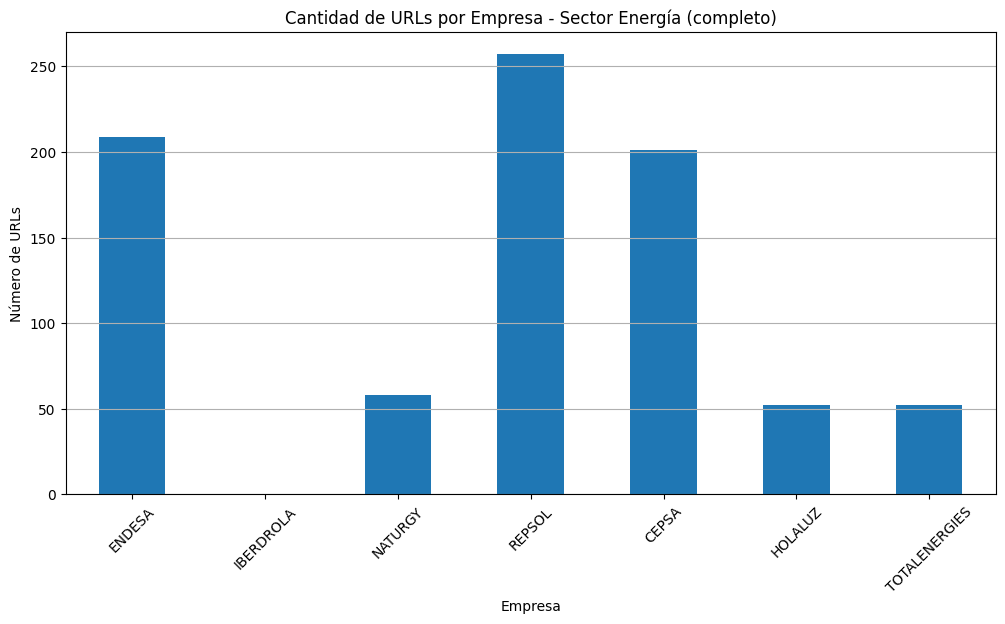

In [15]:
# Lista completa de empresas objetivo para el sector energía
empresas_objetivo_energia = [
    'ENDESA', 'IBERDROLA', 'NATURGY', 'REPSOL', 'CEPSA', 'HOLALUZ', 'TOTALENERGIES'
]

# Normalizar nombres en el DataFrame para evitar discrepancias
df_energia_limpio['empresa'] = df_energia_limpio['empresa'].str.upper().str.strip()

# Contar URLs por empresa
distribucion = df_energia_limpio['empresa'].value_counts()

# Reindexar para incluir todas las empresas objetivo, rellenando con 0 donde no haya datos
distribucion = distribucion.reindex(empresas_objetivo_energia, fill_value=0)

print("Distribución completa de URLs por empresa (incluyendo empresas sin datos):")
print(distribucion)

# Graficar distribución completa
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
distribucion.plot(kind='bar')
plt.title('Cantidad de URLs por Empresa - Sector Energía (completo)')
plt.xlabel('Empresa')
plt.ylabel('Número de URLs')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [12]:
import os

# Definimos la ruta base donde guardaremos los datos procesados
base_path_processed = '/Users/test/Desktop/phishing-detector/data/processed/legitimas'

# Nos aseguramos de que la carpeta exista; si no, la creamos
os.makedirs(base_path_processed, exist_ok=True)

# Definimos el nombre del archivo limpio que vamos a guardar
archivo_limpio = 'energia_legitimas_limpio.csv'

# Construimos la ruta completa para guardar el archivo
ruta_guardado = os.path.join(base_path_processed, archivo_limpio)

# Seleccionamos solo las columnas relevantes para el modelo (empresa y url)
columnas_relevantes = ['empresa', 'url']

# Creamos un nuevo DataFrame con las columnas seleccionadas y eliminamos filas duplicadas
df_modelo = df_energia_limpio[columnas_relevantes].drop_duplicates()

# Imprimimos el número de filas que tiene el DataFrame final limpio
print(f"Filas tras eliminar duplicados en columnas relevantes: {len(df_modelo)}")

# Guardamos el DataFrame limpio en formato CSV, sin incluir el índice
df_modelo.to_csv(ruta_guardado, index=False)

# Confirmamos con un mensaje que el archivo se ha guardado correctamente
print(f"Dataset limpio guardado en: {ruta_guardado}")


Filas tras eliminar duplicados en columnas relevantes: 829
Dataset limpio guardado en: /Users/test/Desktop/phishing-detector/data/processed/legitimas/energia_legitimas_limpio.csv
